# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML/data
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML/data


In [ ]:
! pip install keras-vis

# Install

In [ ]:
! pip install reproject

In [ ]:
! pip install healpy
! pip install reproject

In [ ]:
! pip install tqdm

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys, os

import numpy as np
from keras import models

from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.wcs import WCS
from astropy.table import Table


from scipy.interpolate import interp1d

import healpy as hp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import glob
import pickle
from tqdm import tqdm

from pathlib import Path

from spectral_cube import SpectralCube
from reproject import reproject_from_healpix, reproject_to_healpix

In [ ]:
import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Convolution1D, Dense, Dropout, Flatten, Input, Dense
from vis.utils import utils

from sklearn.model_selection import KFold
from keras.models import load_model

# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'
misc_path     = base_path / 'misc'
galfa_path    = data_path / 'GALFA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

training_data_pkl_file = data_path / 'training_data_kok14_galfa.pickle'
fcnm_cnn_file = data_path / 'fcnm_zea.fits'
rhi_cnn_file = data_path / 'rhi_zea.fits'
observed_catalog_file = data_path / 'catalogged_verification.fits'

model_path = base_path / 'models'

print(tano_signal_path)
print(checkpoint_path)
print(ct101_checkpoint_path)
print(cnn101_checkpoint_path)
print('UMA: ', uma_data_path)

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube


    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()

    print(f"Cube shape: {c.shape}")

    del dat

    _, _, x = c.world[0, 0, :]    # extract RA
    _, y, _ = c.world[0, :, 0]    # extract DEC
    v, _, _ = c.world[:, 0, 0]    # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def plott_(im, title, label):
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='cividis')
    cbar = plt.colorbar(shrink=0.5, pad=0.005)
    cbar.set_label(f'${label}$', size=16)
    plt.title(f'{title}')
    plt.gca().invert_yaxis()
    plt.xlabel('X [Coordinate]')
    plt.ylabel('Y [Coordinate]')
    plt.show()

# Download data

In [ ]:
# Download external data:
download = False
if download:
    # Training and test spectra
    !wget -O training_data_kok14_galfa.pickle https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/QT6NPF/79N7YU
    # fCNM CNN maps and uncertainties
    !wget -O fcnm_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/28QM9F
    # RHI CNN maps and uncertainties
    !wget -O rhi_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/WJZMPD
    # Observed catalog
    !wget -O catalogged_verification.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/MJGQAY/D2RS4E

In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/ML/data


# Read training dataset

In [ ]:
data = pickle.load(open(training_data_pkl_file, 'rb'))

# Synthetic training data
X_train = data['X_train']
Y_train = data['Y_train']

# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

# Re-shape network inputs
X_train = X_train.reshape(X_train.shape[0],  X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],  X_test.shape[1], 1)

In [ ]:
X_train.shape

(38781, 414, 1)

In [ ]:
X_test.shape

(58, 414, 1)

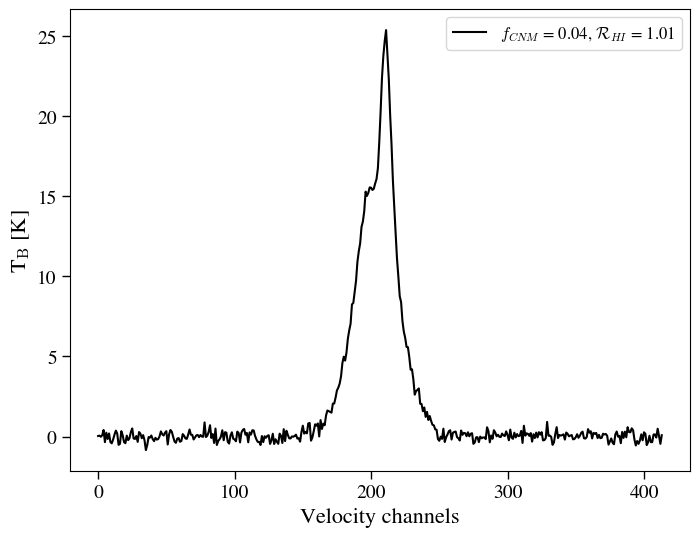

In [ ]:
# Spectrum in training set
# plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))
spec_id = 0
fcnm_i = round(Y_train[spec_id, 0], 2)
rhi_i  = round(Y_train[spec_id, 1], 2)
# plt.plot(data[:, j, i], label='data')
ax.plot(X_train[spec_id, :, 0], 'k-', label=r'$f_{CNM}$ = '+str(fcnm_i)+', $\mathcal{R}_{HI}$ = '+str(rhi_i))

# plt.title('Training set')
ax.set_xlabel('Velocity channels', fontsize=16)
ax.set_ylabel('T$_\mathrm{B}$ [K]', fontsize=16)
ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=14)

plt.legend(loc='upper right', fontsize=12)

plt.show()

# Build and train the convolutional neural network

Construct the 1D CNN, compile it, and fit the parameters using the training data.

In [ ]:
batch_size = 16
num_epochs = 128

cnn = Sequential((
    Convolution1D(8, 6, activation='relu', input_shape=X_train.shape[1:3],name = 'firstconv'),
    Convolution1D(8, 40, activation='relu', name = 'midconv'),
    Flatten(),
    Dropout(0.3),
    Dense(2, activation='linear', name = 'preds'),
))
cnn.compile(loss='mse', optimizer='adam')

# cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1,  validation_split=0.3)

In [ ]:
if False:
  # define 10-fold cross validation test harness
  kf = KFold(n_splits=10)
  kf.get_n_splits(X_train)

  cvscores = []
  for i, (train_index, val_index) in tqdm(enumerate(kf.split(X_train, Y_train.argmax(1)))):
      x_train_kf, x_val_kf = X_train[train_index], X_train[val_index]
      y_train_kf, y_val_kf = Y_train[train_index], Y_train[val_index]

      cnn_kf = Sequential((
          Convolution1D(8, 6, activation='relu', input_shape=x_train_kf.shape[1:3]),
          Convolution1D(8, 40, activation='relu'),
          Flatten(),
          Dropout(0.3),
          Dense(2, activation='linear'),
      ))
      cnn_kf.compile(loss='mse', optimizer='adam', metrics=['mae','acc'])

      cnn_kf.fit(x_train_kf, y_train_kf, epochs=num_epochs, batch_size=batch_size, verbose=1)

      # evaluate the model
      scores = cnn_kf.evaluate(x_val_kf, y_val_kf, verbose=0)
      print("%s: %.2f%%" % (cnn_kf.metrics_names[1], scores[1]*100))

      cvscores.append(scores[1] * 100)

In [ ]:
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Apply trained model to observed data

In [ ]:
if False:
  # Generate predictions
  Y_pred = cnn_kf.predict(X_test)
  Y_pred.shape

In [ ]:
# Save the trained model
trained_cnn_model = model_path / 'trained_model.keras'

if False:
  cnn_kf.save(trained_cnn_model)

# Load trained model

In [ ]:
loaded_model = load_model(trained_cnn_model)

In [ ]:
if False:
  # Generate predictions
  Y_pred = loaded_model.predict(X_test)
  Y_pred.shape

In [ ]:
if False:
  # Set the font family for math symbols
  plt.rcParams["mathtext.fontset"] = "custom"
  plt.rcParams["mathtext.rm"] = "Times New Roman"
  plt.rcParams["mathtext.it"] = "Times New Roman:italic"
  plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111)


  color_ = 'k'
  sct1 = ax.scatter(Y_test[:,0], Y_pred[:,0],
                    zorder=2, s=8,
                    marker='o', c=color_, vmin=0., vmax=37.,
                    facecolors='none', edgecolors=color_,
                    label=f'Test: {len(Y_pred[:,0])}')

  ax.set_xlabel(r'Ground truth $f_{CNM}$ (from observation)', fontsize=16)
  ax.set_ylabel(r'Prediction $f_{CNM}$ (CNN model)', fontsize=18)

  ax.tick_params(axis='x', labelsize=12, pad=4)
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(which='both', width=2)
  ax.tick_params(which='major', length=4)
  ax.tick_params(which='minor', length=2)

  plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
  plt.legend(loc='lower right', fontsize=10)

  plt.show()

# Read Data cube

In [ ]:
# Observed datasets
filename = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits'
print(filename)

data_file = uma_data_path / filename
data_file

# Spectal res: 1. km/s
# Channel spacing: 0.824 km/s

GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits


PosixPath('/content/gdrive/MyDrive/Colab Notebooks/ML/data/UMA/GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits')

In [ ]:
data, hdr = fits.getdata(data_file, header=True)
data = np.squeeze(data)

hdr['CUNIT3'] = 'm/s'

fits.writeto(data_file, data, hdr, overwrite=True)

In [ ]:
cube, cube_wcs, cube_gl, cube_gb, cube_vlsr, cube_hdr = read_fits_cube(data_file)
print(cube_wcs)
print(cube)

Cube shape: (654, 495, 603)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-GLS' 'GLAT-GLS' 
CRVAL : 140.657081396 0.0 
CRPIX : 305.0 -364.1708374 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05833333358 0.05833333358 
NAXIS : 0  0
SpectralCube with shape=(654, 495, 603) and unit=K:
 n_x:    603  type_x: GLON-SFL  unit_x: deg    range:   113.546649 deg:  168.313361 deg
 n_y:    495  type_y: GLAT-SFL  unit_y: deg    range:    21.301632 deg:   50.118299 deg
 n_s:    654  type_s: VOPT-F2W  unit_s: m / s  range:  -311210.220 m / s:  214332.215 m / s


In [ ]:
m0 = cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
nhi_thin_full = np.array(m0)*0.018224

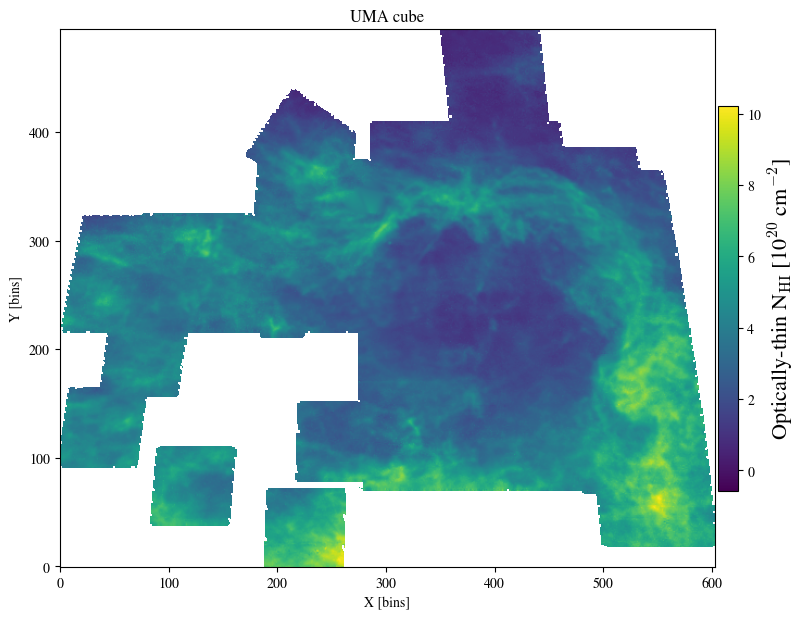

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(nhi_thin_full, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
cube_vlsr = np.array(cube_vlsr)/1000.
dv = np.abs(np.mean(np.diff(cube_vlsr)))
dv

0.8048123037229088

In [ ]:
data, hdr = fits.getdata(data_file, header=True)

data = data[215:369,246:374, 197:325]
data = data[85:, :, :] # data[85:, :, :], [79:, :, :]
data.shape

(69, 128, 128)

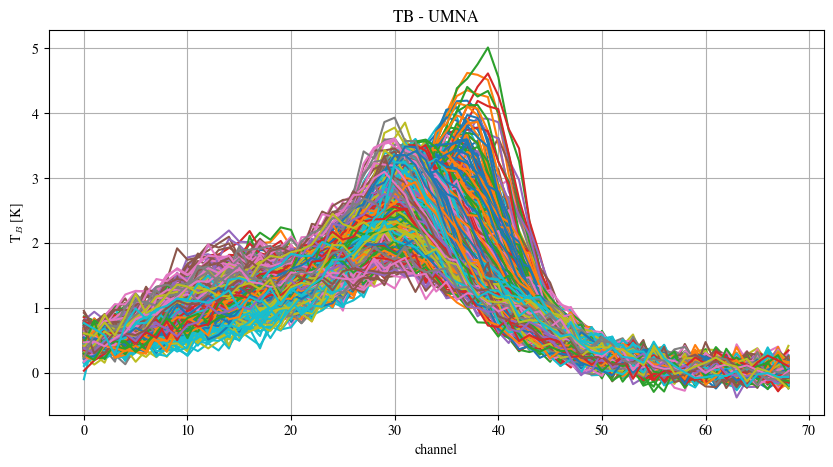

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(data[:, 20+j, 20+i])

plt.title('TB - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
plt.grid()
# fig.savefig('', bbox_inches='tight')
plt.show()

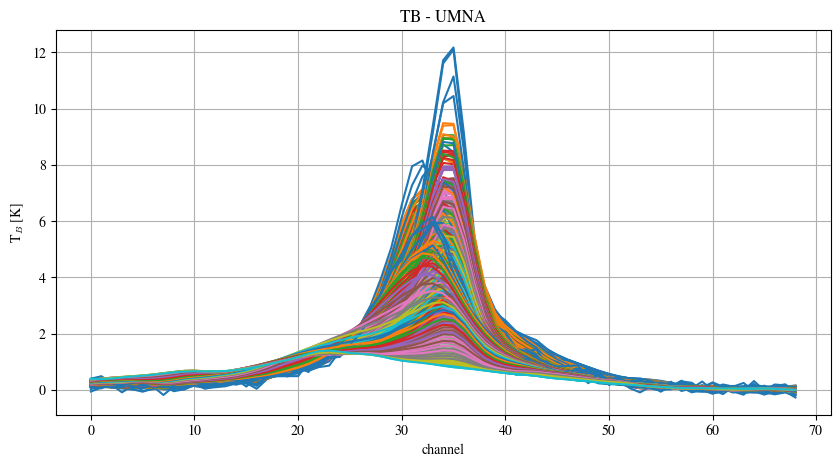

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(data[:, 80+j, 80+i])

plt.title('TB - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
plt.grid()
# fig.savefig('', bbox_inches='tight')
plt.show()

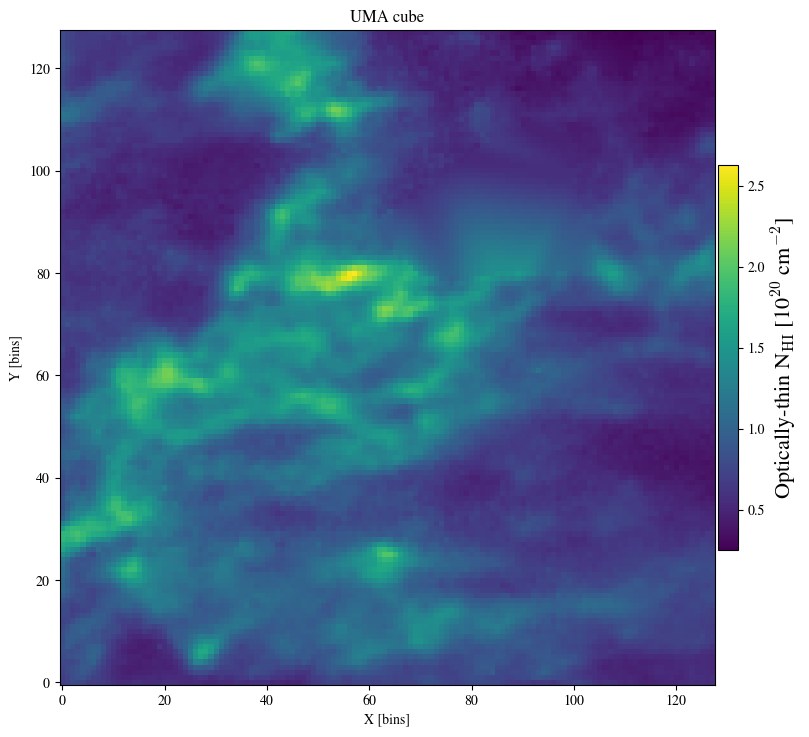

In [ ]:
nhi_thin = 0.018224 * np.sum(data, axis=0) * dv


plt.figure(figsize=(10,10))
plt.imshow(nhi_thin, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
subcube = cube[215:369,246:374, 197:325]
subcube = subcube[79:, :, :]
subcube.shape

(75, 128, 128)

In [ ]:
subcube_vlsr, _, _ = np.asarray(subcube.world[:, 0, 0])/1000.

In [ ]:
print(subcube)

SpectralCube with shape=(75, 128, 128) and unit=K:
 n_x:    128  type_x: GLON-SFL  unit_x: deg    range:   139.060307 deg:  149.199826 deg
 n_y:    128  type_y: GLAT-SFL  unit_y: deg    range:    35.651632 deg:   43.059966 deg
 n_s:     75  type_s: VOPT-F2W  unit_s: m / s  range:   -82065.325 m / s:  -22510.699 m / s


In [ ]:
subcube.wcs.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SFL' 'GLAT-SFL' 
CRVAL : 140.657081396 0.0 
CRPIX : 108.0 -610.1708374 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05833333358 0.05833333358 
NAXIS : 0  0

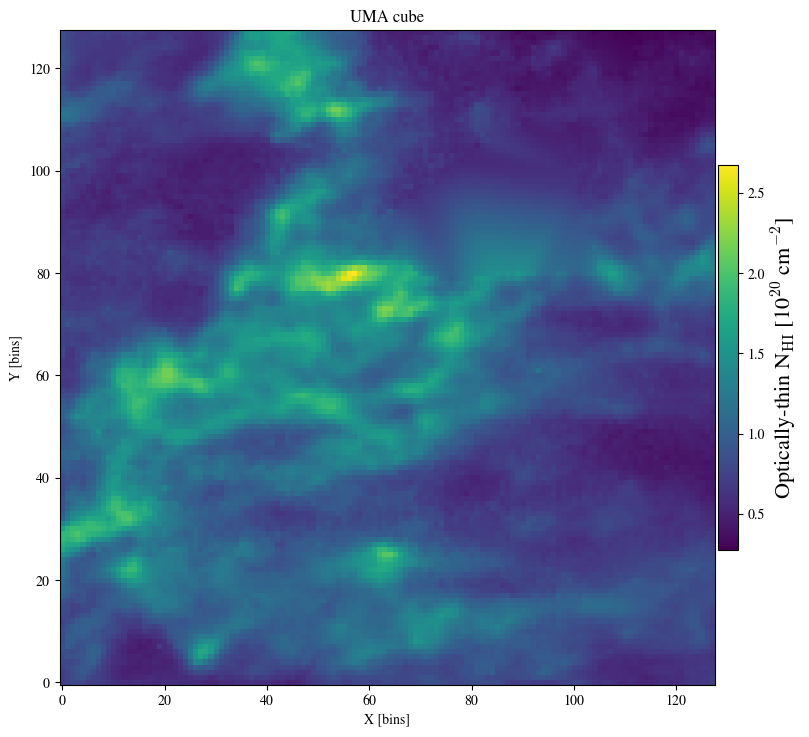

In [ ]:
m0_subcube = subcube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
nhi_thin_sc = np.array(m0_subcube)*0.018224

nhi_thin = 0.018224 * np.sum(data, axis=0) * dv

plt.figure(figsize=(10,10))
plt.imshow(nhi_thin_sc, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
wcs_2D = subcube.wcs.celestial

## CNM cube

In [ ]:
cnm_cube, cnm_hdr = fits.getdata(uma_data_path / 'GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits', header=True)
cnm_cube.shape

(69, 128, 128)

In [ ]:
# cnm_hdr

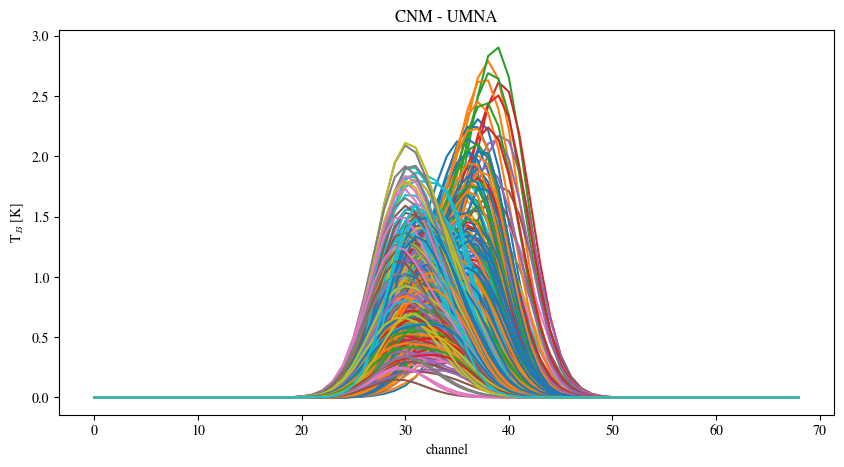

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(cnm_cube[:, 20+j, 20+i])

plt.title('CNM - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

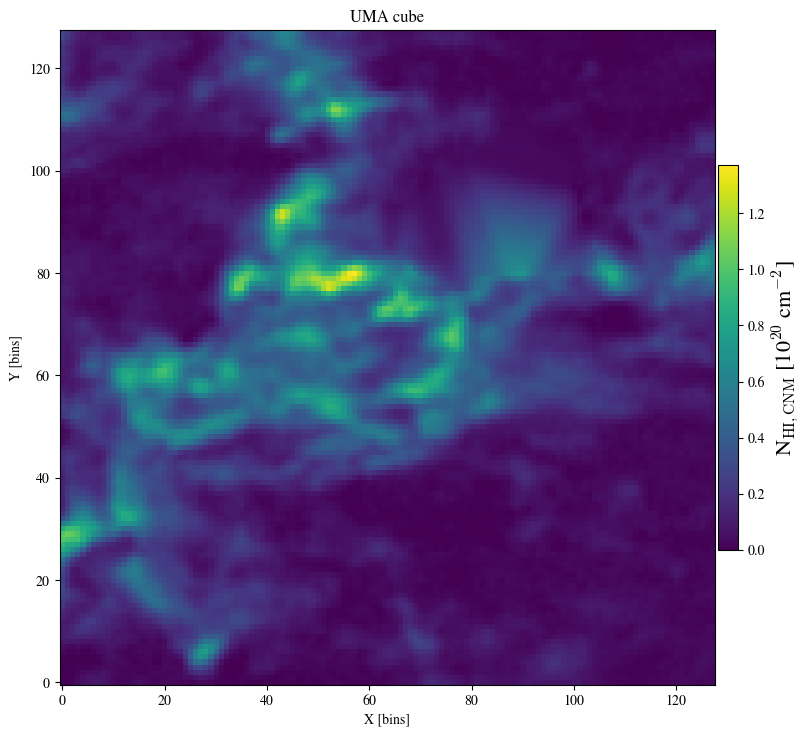

In [ ]:
# CNM - NHI
nhi_cnm = 0.018224 * np.sum(cnm_cube, axis=0) * dv

plt.figure(figsize=(10,10))
plt.imshow(nhi_cnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

## WNM cube

In [ ]:
wnm_cube, wnm_hdr = fits.getdata(uma_data_path / 'GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits', header=True)
wnm_cube.shape

(69, 128, 128)

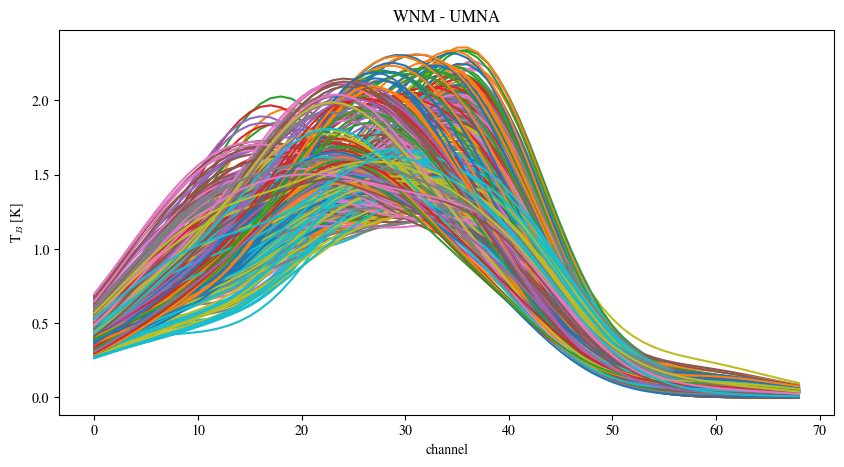

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(wnm_cube[:, 20+j, 20+i])

plt.title('WNM - UMNA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

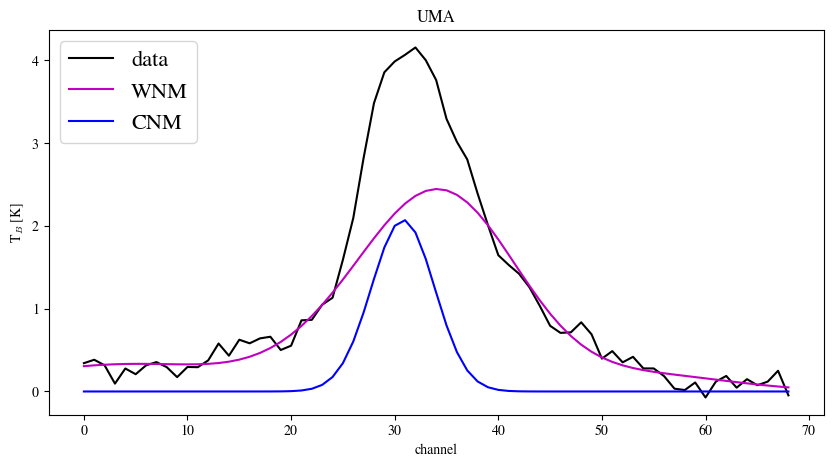

In [ ]:
i = 64
j = 64
fig = plt.figure(figsize=(10,5))

plt.plot(data[:, j, i], 'k-', label='data')
plt.plot(wnm_cube[:, j, i], 'm-', label='WNM')
plt.plot(cnm_cube[:, j, i], 'b-', label='CNM')

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file

plt.legend(loc='upper left', fontsize=16)
plt.show()

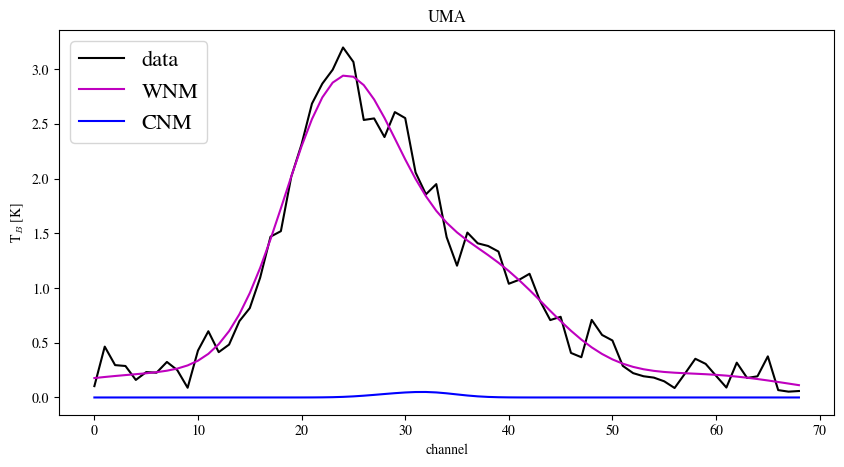

In [ ]:
i = 6
j = 4
fig = plt.figure(figsize=(10,5))

plt.plot(data[:, j, i], 'k-', label='data')
plt.plot(wnm_cube[:, j, i], 'm-', label='WNM')
plt.plot(cnm_cube[:, j, i], 'b-', label='CNM')

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file

plt.legend(loc='upper left', fontsize=16)
plt.show()

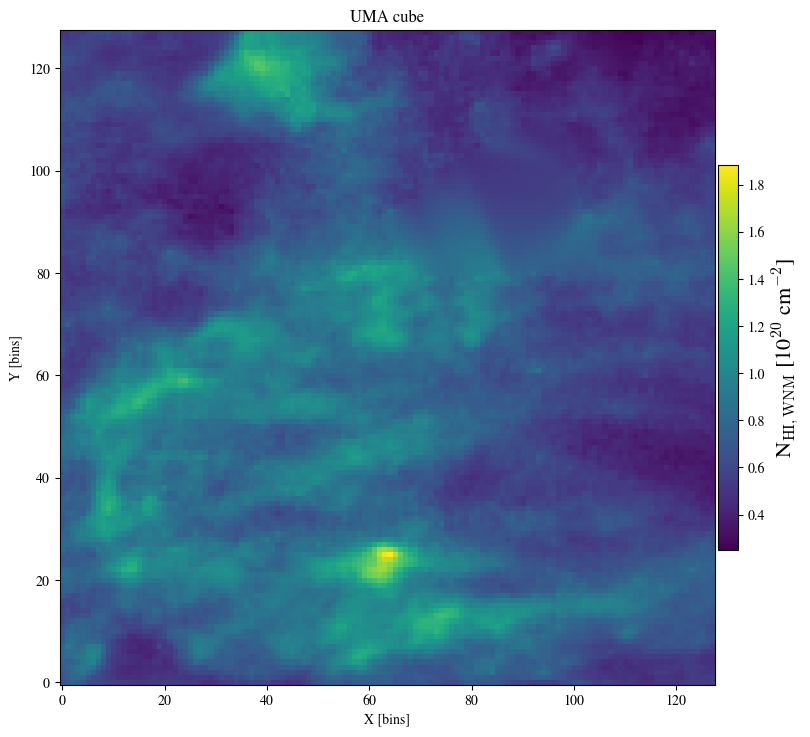

In [ ]:
# CNM - NHI
nhi_wnm = 0.018224 * np.sum(wnm_cube, axis=0) * dv

plt.figure(figsize=(10,10))
plt.imshow(nhi_wnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, WNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

## $f_\text{CNM}$ in optically-thin limit

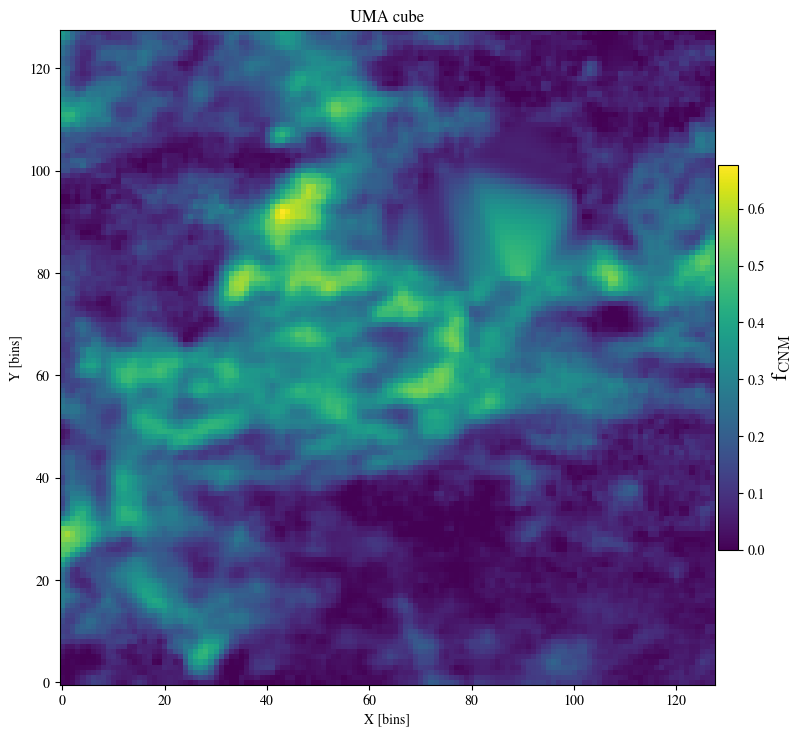

In [ ]:
fcnm_thin = nhi_cnm / nhi_thin

# CNM - NHI
plt.figure(figsize=(10,10))
plt.imshow(fcnm_thin, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('f$_\mathrm{CNM}$', size=16)

plt.title('UMA cube')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
np.savez(tanosignal_pred_path / 'uma' / f'fcnm_thin.npz', x=fcnm_thin)
print(tanosignal_pred_path / 'uma' / f'fcnm_thin.npz')

/content/gdrive/MyDrive/Colab Notebooks/ML/tano_signal/pred/uma/fcnm_thin.npz


## $f_\text{CNM}$ map from Fourier Transform (FFT)

In [ ]:
cnm_data_file = uma_data_path / 'cnm_fft.fits'
print(cnm_data_file)

fft_nhi_cnm = fits.getdata(cnm_data_file) / 10. # in unit of 1e20
fft_nhi_cnm.shape

/content/gdrive/MyDrive/Colab Notebooks/ML/data/UMA/cnm_fft.fits


(128, 128)

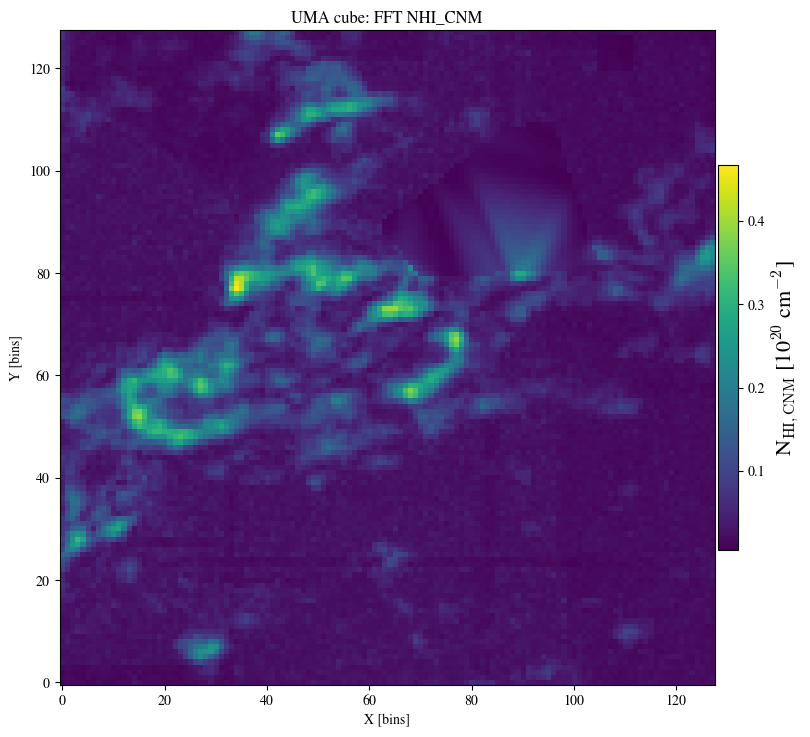

In [ ]:
# CNM - NHI
plt.figure(figsize=(10,10))
plt.imshow(fft_nhi_cnm, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('N$_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', size=16)

plt.title('UMA cube: FFT NHI_CNM')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

# Data preprocessing

In [ ]:
nchan, ny, nx = data.shape
print(nchan, ny, nx)

69 128 128


In [ ]:
print(nx, ny)

128 128


In [ ]:
num = ny*nx
num

16384

In [ ]:
# TB max
tbmax_map = np.max(data, axis=0)
tbmax_flat = tbmax_map.flatten()

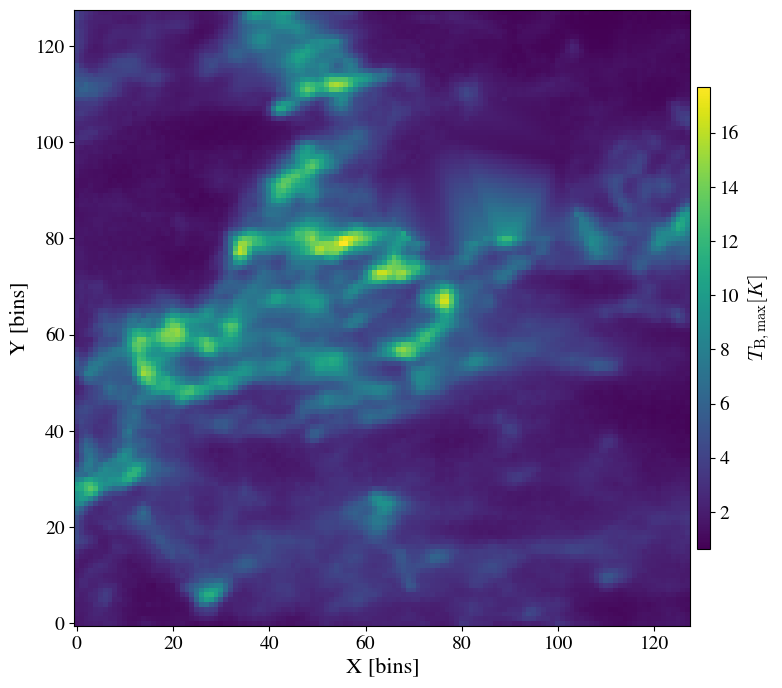

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(tbmax_map, cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=16)
ax.set_ylabel("Y [bins]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$T_\mathrm{B, max} [K]$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
# fig.savefig(filename.replace('.FITS', '_zoom.jpg'), bbox_inches='tight')   # save the figure to file
plt.show()
plt.close()

# To new channel grid

In [ ]:
x = np.linspace(0, nchan, nchan, endpoint=False)
x[-3:]

array([66., 67., 68.])

In [ ]:
# Interpolate into new vlsr channel grid
nchan_new = 414
x_new = np.linspace(0, nchan, nchan_new, endpoint=True)
print(x_new[-3:])
print(x_new.shape)

new_cube = np.zeros((nchan_new, ny, nx))
for i,j in np.ndindex(nx,ny):
    new_cube[:, j, i] = np.interp(x_new, x, data[:, j, i])

[68.66585956 68.83292978 69.        ]
(414,)


In [ ]:
new_cube.shape

(414, 128, 128)

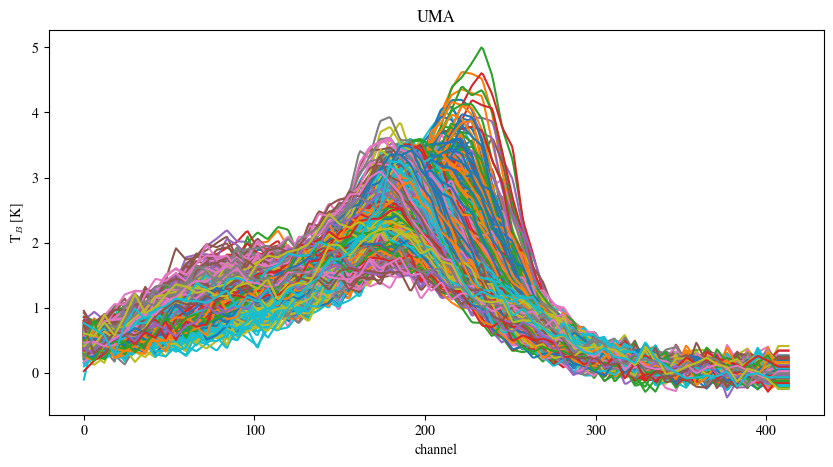

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(new_cube[:, 20+j, 20+i])

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

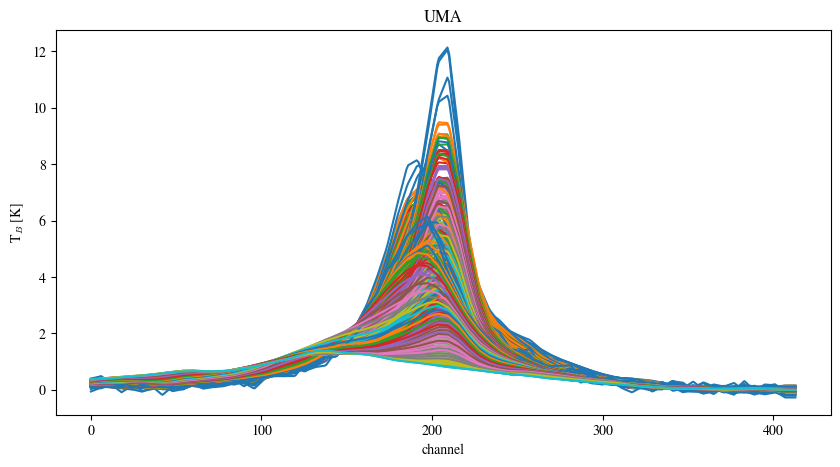

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(new_cube[:, 80+j, 80+i])

plt.title('UMA')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

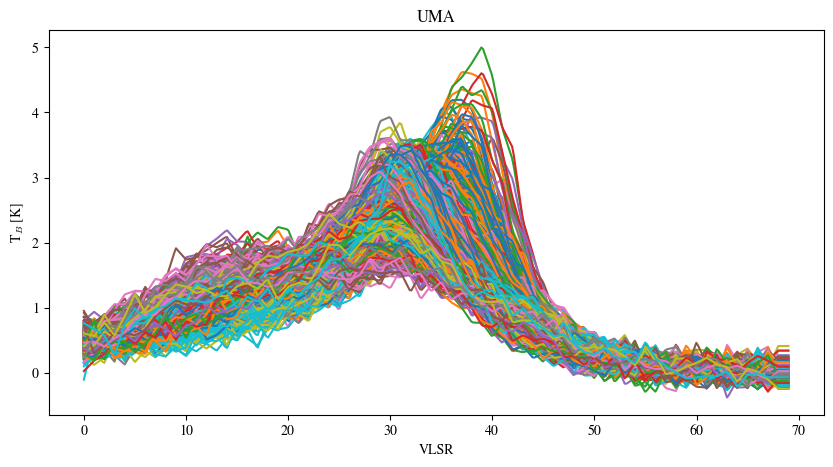

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(x_new, new_cube[:, 20+j, 20+i])

plt.title('UMA')
plt.xlabel('VLSR')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

In [ ]:
X_data = np.zeros((nx*ny, 414, 1))
X_data.shape

(16384, 414, 1)

In [ ]:
k = 0
for (i,j) in np.ndindex(nx,ny):
  X_data[k, :, 0] = new_cube[:, j, i]
  k = k + 1

In [ ]:
X_data.shape

(16384, 414, 1)

In [ ]:
Y_data_pred = loaded_model.predict(X_data)
Y_data_pred

512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


array([[0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       ...,
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006332 ],
       [0.00727808, 1.0006332 ]], dtype=float32)

In [ ]:
Y_data_pred.shape

(16384, 2)

In [ ]:
Y_data_pred_maps = np.reshape(Y_data_pred.copy(), (ny,nx,2), order='F')
Y_data_pred_maps.shape

(128, 128, 2)

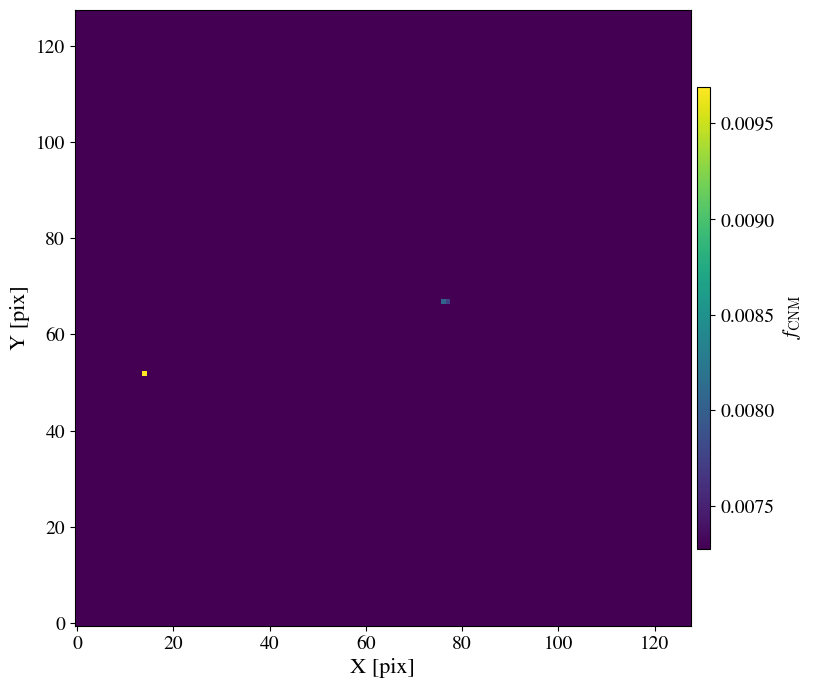

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,0], cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

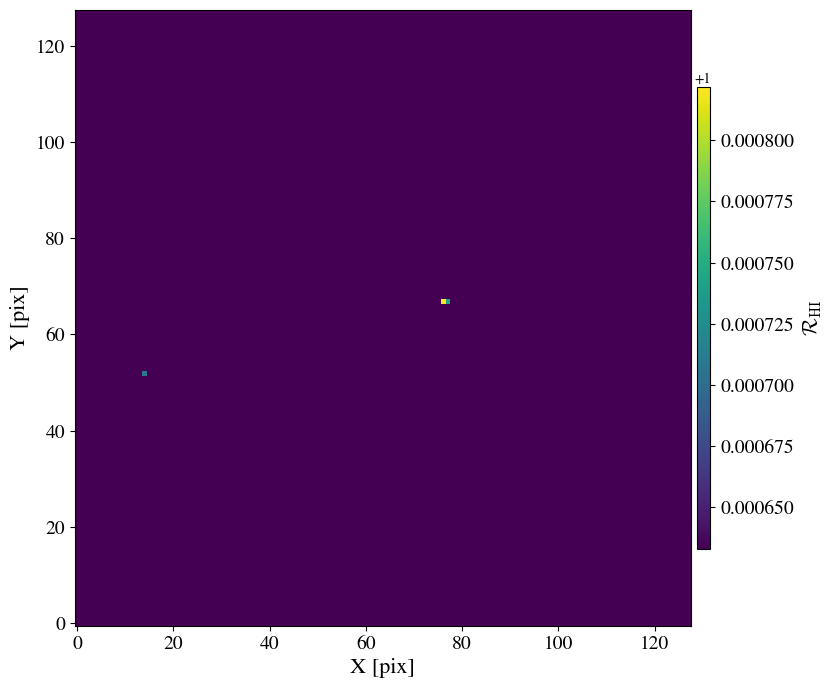

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,1], cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

# Centralize the data cube


In [ ]:
nchan, ny, nx = data.shape
print(nchan, ny, nx)

69 128 128


In [ ]:
noise = np.std(data[-10:, :, :], axis=0).mean()
noise

0.08442012

In [ ]:
# Centralize the data cube by appending noise to the 2 ends
noise_maps = [np.random.normal(0, noise, (ny,nx)) for _ in range(33)]

noise_std = np.stack(noise_maps, axis=0)
print(noise_std.shape)

# Append noise to the two ends of each spectrum
datacube = np.concatenate((noise_std, noise_std, data, noise_std, noise_std), axis=0)
print(datacube.shape)

(33, 128, 128)
(201, 128, 128)


In [ ]:
# Add noise to the synthetic data cube
nchan, ny, nx = datacube.shape
noise = 0.5
for i in range(nx):
  for j in range(ny):
    datacube[:, j, i] += np.random.randn(nchan) * noise

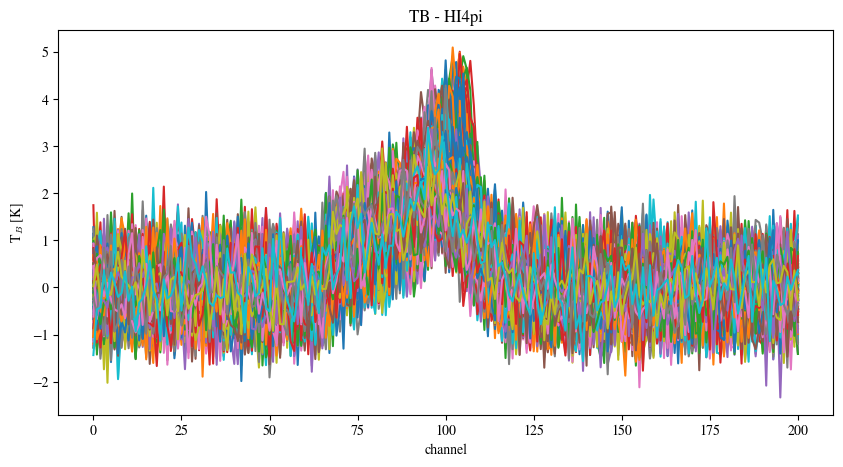

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(datacube[:, 20+j, 20+i])

plt.title('TB - HI4pi')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

# Centralize and to new channel grid

In [ ]:
nchan, ny, nx = datacube.shape
print(nchan, ny, nx)

201 128 128


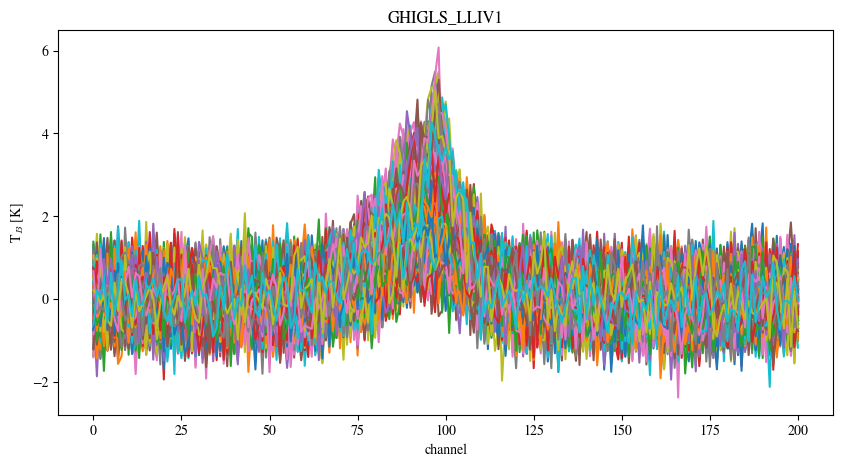

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(datacube[:, j, i])

plt.title('GHIGLS_LLIV1')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

In [ ]:
# Interpolate into new vlsr channel grid
x = np.linspace(0, nchan, nchan, endpoint=False)
x[-3:]

array([198., 199., 200.])

In [ ]:
# Interpolate into new vlsr channel grid
nchan_new = 414
x_new = np.linspace(0, nchan, nchan_new, endpoint=True)
print(x_new[-3:])
print(x_new.shape)

new_cube = np.zeros((nchan_new, ny, nx))
for i,j in np.ndindex(nx,ny):
    new_cube[:, j, i] = np.interp(x_new, x, datacube[:, j, i])

[200.02663438 200.51331719 201.        ]
(414,)


In [ ]:
new_cube.shape

(414, 128, 128)

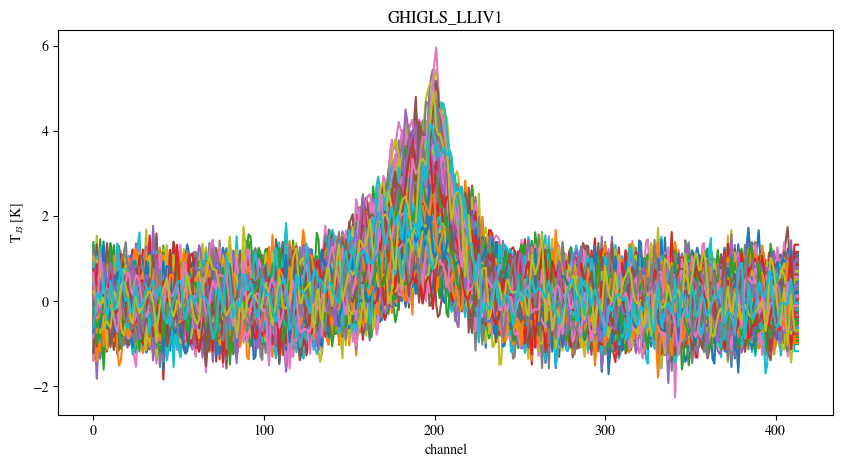

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(new_cube[:, j, i])

plt.title('GHIGLS_LLIV1')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

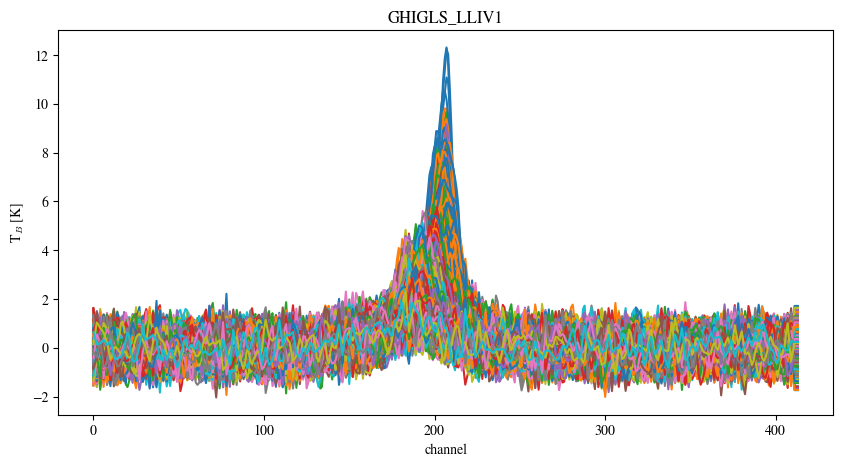

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(40,40):
    plt.plot(new_cube[:, 80+j, 80+i])

plt.title('GHIGLS_LLIV1')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

In [ ]:
new_cube.shape

(414, 128, 128)

In [ ]:
X_data = np.zeros((nx*ny, 414, 1))
X_data.shape

(16384, 414, 1)

In [ ]:
# Input shape as required by the CNN model
k = 0
for (i,j) in np.ndindex(nx,ny):
  X_data[k, :, 0] = new_cube[:, j, i]
  k = k + 1

In [ ]:
X_data.shape

(16384, 414, 1)

In [ ]:
Y_data_pred = loaded_model.predict(X_data)
Y_data_pred

512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


array([[-0.01067766,  0.98698026],
       [ 0.00107645,  0.9868275 ],
       [ 0.0071224 ,  0.9978845 ],
       ...,
       [-0.01805661,  0.9999356 ],
       [ 0.00905491,  0.9976821 ],
       [ 0.02029789,  0.9965863 ]], dtype=float32)

In [ ]:
Y_data_pred.shape

(16384, 2)

In [ ]:
Y_data_pred_maps = np.reshape(Y_data_pred.copy(), (ny,nx,2), order='F')
Y_data_pred_maps.shape

(128, 128, 2)

In [ ]:
print(np.min(Y_data_pred_maps[:,:,0]))
print(np.max(Y_data_pred_maps[:,:,0]))

print(np.min(Y_data_pred_maps[:,:,1]))
print(np.max(Y_data_pred_maps[:,:,1]))

-0.055611044
0.2131402
0.96012205
1.0705858


In [ ]:
fcnm_cnn_m20 = Y_data_pred_maps[:,:,0]
rhi_cnn_m20 = Y_data_pred_maps[:,:,1]

In [ ]:
print(np.min(fcnm_cnn_m20), np.median(fcnm_cnn_m20), np.mean(fcnm_cnn_m20), np.max(fcnm_cnn_m20))
print(np.min(rhi_cnn_m20), np.median(rhi_cnn_m20), np.mean(rhi_cnn_m20), np.max(rhi_cnn_m20))

0.0 0.0052748695 0.010087868 0.2131402
1.0 1.0 1.0007687 1.0705858


In [ ]:
nhi_cnm_cnn_cen = fcnm_cnn_m20 * rhi_cnn_m20 * nhi_thin

# Predictions from PEs

In [ ]:
saury_pred_path = tanosignal_pred_path / 'uma'
print(saury_pred_path)

/content/gdrive/MyDrive/Colab Notebooks/ML/tano_signal/pred/uma


In [ ]:
print(nx, ny)

128 128


In [ ]:
npz_file = tanosignal_pred_path / 'uma' / f'ctrans_fcnm_rhi_LLIV1.npz'
npzdata = np.load(npz_file)
fcnm = npzdata['x']
rhi = npzdata['y']
nhi_cnm_ct = npzdata['z']
npzdata.close()

In [ ]:
Fcnm_flat = fcnm.flatten()
Rhi_flat = rhi.flatten()

# Figure 16: tpcNet vs M20 CNN

<ipython-input-135-2fda6f59b140>:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


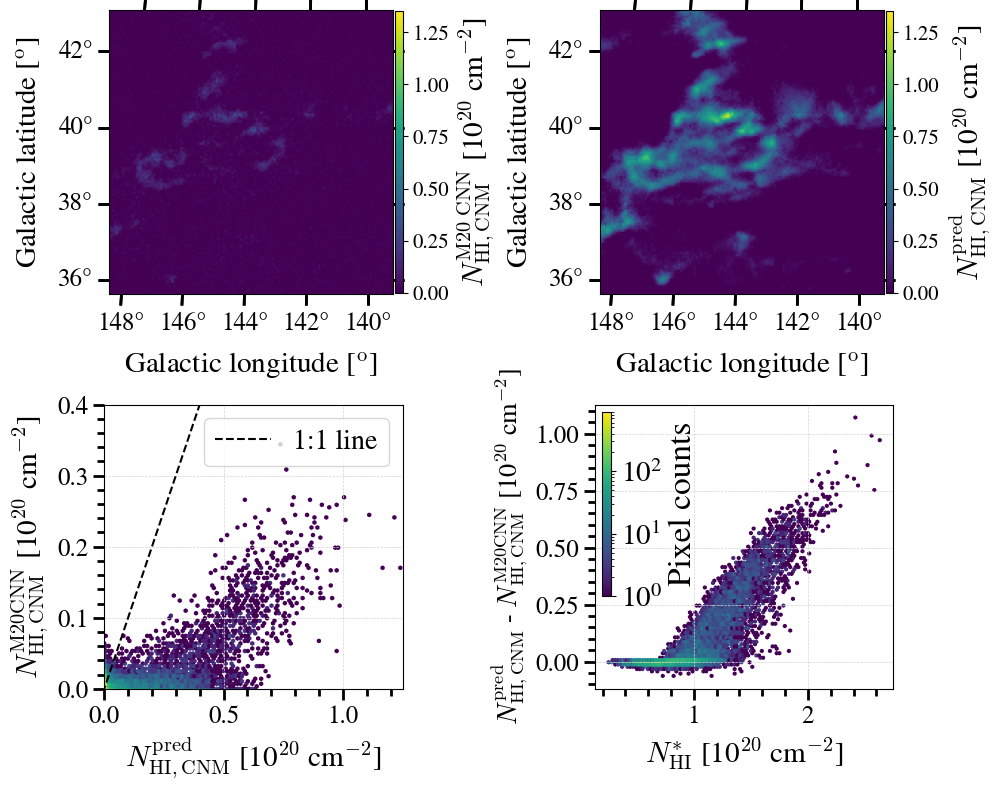

In [ ]:
fig = plt.figure(figsize=(10,8))

tlbs = 18
xlbs = 21
normalizer = LogNorm(1., 9.e2)




# ax
ax = fig.add_subplot(221, projection=wcs_2D)

# moment map image
im = ax.imshow(nhi_cnm_cnn_cen, cmap='viridis', origin='lower', vmin=0., vmax=1.35)

# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{M20\ CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=21)
cbar.ax.tick_params(labelsize=15)






ax = fig.add_subplot(222, projection=wcs_2D)

# moment map image
im = ax.imshow(nhi_cnm_ct, cmap='viridis', origin='lower', vmin=0., vmax=1.35)

# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=21)
cbar.ax.tick_params(labelsize=15)






ax = fig.add_subplot(223)

img = ax.hexbin(nhi_cnm_ct, nhi_cnm_cnn_cen, gridsize=100, cmap='viridis', norm=normalizer)
ax.plot([-0.05, 1.4], [-0.05, 1.4], 'k--', label='1:1 line')

ax.set_ylabel(r'$N^\mathrm{M20 CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)
ax.set_xlabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)

ax.set_xlim(0., 1.25)
ax.set_ylim(0., 0.4)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)
# ax.set_aspect('equal')

ax.legend(loc='upper right', fancybox=True, framealpha=0.8, labelcolor='k', fontsize=xlbs-1)
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)







ax = fig.add_subplot(224)

img = ax.hexbin(nhi_thin.flatten(), nhi_cnm_ct.flatten() - nhi_cnm_cnn_cen.flatten(), gridsize=100, cmap='viridis', norm=normalizer)

axins1 = inset_axes(ax,
                    width="3%",
                    height="65%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('Pixel counts', rotation=90, labelpad=5., fontsize=24)
cbar.ax.tick_params(labelsize=21)


ax.set_ylabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ - $N^\mathrm{M20 CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs-2)
ax.set_xlabel(r'$N^\mathrm{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)
# ax.set_aspect('equal')

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.5,
                    hspace=0.5
                    )

plt.tight_layout()
plt.show()
plt.close()